<a href="https://www.kaggle.com/code/sa1f27/gemma2-quran?scriptVersionId=215592556" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-quran-dataset/The Quran Dataset.csv
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/config.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/tokenizer.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/metadata.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/model.weights.h5
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/assets/tokenizer/vocabulary.spm


In [2]:
import os
import keras_nlp
import keras
import pandas as pd
import time
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

In [3]:
os.environ["KERAS_BACKEND"]="jax"

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

class Config:
    token_limit=256
    lora_name="Quran_Lora"
    lora_rank=4
    lr_value=1e-4
    train_epoch=5
    model_id = "gemma2_instruct_2b_en"

In [4]:
df = pd.read_csv('/kaggle/input/the-quran-dataset/The Quran Dataset.csv')
df.head(1)

,surah_no,surah_name_en,surah_name_ar,surah_name_roman,ayah_no_surah,ayah_no_quran,ayah_ar,ayah_en,ruko_no,juz_no,manzil_no,hizb_quarter,total_ayah_surah,total_ayah_quran,place_of_revelation,sajah_ayah,sajdah_no,no_of_word_ayah,list_of_words
0,1,The Opener,الفاتحة,Al-Fatihah,1,1,بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ,"In the Name of Allah—the Most Compassionate, M...",1,1,1,1,7,6236,Meccan,False,NaN,4,"[بِسْمِ,ٱللَّهِ,ٱلرَّحْمَٰنِ,ٱلرَّحِيمِ]"


In [5]:
import keras
import keras_hub
import numpy as np

tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(Config.model_id)
gemma = keras_nlp.models.GemmaCausalLM.from_preset(Config.model_id)
gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [6]:
train = []

for i,x in tqdm(df.iterrows(), desc='tokenize dataset'):
    item = f"<start_of_turn>user\n{x['ayah_en']}<end_of_turn>\n<start_of_turn>system\n{x['ayah_ar']}<end_of_turn>"
    length = len(tokenizer(item))
    if length < Config.token_limit:
        train.append(item)

print(len(train))
print(train[0])
print(train[1])
print(train[4])

tokenize dataset: 0it [00:00, ?it/s]

5772
<start_of_turn>user
In the Name of Allah—the Most Compassionate, Most Merciful.<end_of_turn>
<start_of_turn>system
بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ<end_of_turn>
<start_of_turn>user
All praise is for Allah—Lord of all worlds,<end_of_turn>
<start_of_turn>system
ٱلْحَمْدُ لِلَّهِ رَبِّ ٱلْعَٰلَمِينَ<end_of_turn>
<start_of_turn>user
You ˹alone˺ we worship and You ˹alone˺ we ask for help.<end_of_turn>
<start_of_turn>system
إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ<end_of_turn>


In [7]:
tick_start = 0


def tick():
    global tick_start
    tick_start = time.time()


def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")


def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma.generate(input, max_length=Config.token_limit)
    print("\nGemma output:")
    print(output)
    tock()

In [8]:
text_gen('In the Name of Allah—the Most Compassionate, Most Merciful.')


Gemma output:
<start_of_turn>user
In the Name of Allah—the Most Compassionate, Most Merciful.<end_of_turn>
<start_of_turn>model
This is a beautiful and powerful phrase in Arabic. 

**Here's a breakdown:**

* **"In the Name of Allah"** - This is a common phrase in Islamic prayer and is a declaration of faith. It signifies that the prayer is being offered in the name of Allah, the Arabic word for God.
* **"the Most Compassionate, Most Merciful"** - These are attributes of Allah, highlighting His kindness, love, and forgiveness. 

**Why is this phrase important?**

* **Declaration of Faith:** It signifies the believer's commitment to Allah and their belief in His power and mercy.
* **Focus on Allah:** It reminds the believer to focus on Allah and seek His guidance in all aspects of life.
* **Seeking Allah's Mercy:** It acknowledges the importance of seeking Allah's forgiveness and mercy.


It's a beautiful and meaningful phrase that carries deep spiritual significance in Islam. 
<end_of_

In [9]:
gemma.backbone.enable_lora(rank=Config.lora_rank)
gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [10]:
gemma.preprocessor.sequence_length = Config.token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=Config.lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [11]:
df.tail()

,surah_no,surah_name_en,surah_name_ar,surah_name_roman,ayah_no_surah,ayah_no_quran,ayah_ar,ayah_en,ruko_no,juz_no,manzil_no,hizb_quarter,total_ayah_surah,total_ayah_quran,place_of_revelation,sajah_ayah,sajdah_no,no_of_word_ayah,list_of_words
6231,114,The Mankind,الناس,An-Nas,2,6232,مَلِكِ ٱلنَّاسِ,"the Master of humankind,",556,30,7,240,6,6236,Meccan,False,NaN,2,"[مَلِكِ,ٱلنَّاسِ]"
6232,114,The Mankind,الناس,An-Nas,3,6233,إِلَٰهِ ٱلنَّاسِ,"the God of humankind,",556,30,7,240,6,6236,Meccan,False,NaN,2,"[إِلَٰهِ,ٱلنَّاسِ]"
6233,114,The Mankind,الناس,An-Nas,4,6234,مِن شَرِّ ٱلْوَسْوَاسِ ٱلْخَنَّاسِ,from the evil of the lurking whisperer—,556,30,7,240,6,6236,Meccan,False,NaN,4,"[مِن,شَرِّ,ٱلْوَسْوَاسِ,ٱلْخَنَّاسِ]"
6234,114,The Mankind,الناس,An-Nas,5,6235,ٱلَّذِى يُوَسْوِسُ فِى صُدُورِ ٱلنَّاسِ,who whispers into the hearts of humankind—,556,30,7,240,6,6236,Meccan,False,NaN,5,"[ٱلَّذِى,يُوَسْوِسُ,فِى,صُدُورِ,ٱلنَّاسِ]"
6235,114,The Mankind,الناس,An-Nas,6,6236,مِنَ ٱلْجِنَّةِ وَٱلنَّاسِ,from among jinn and humankind.”,556,30,7,240,6,6236,Meccan,False,NaN,5,"[ٱلَّذِى,يُوَسْوِسُ,فِى,صُدُورِ,ٱلنَّاسِ]"


Epoch 1/5
5772/5772 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7749 - sparse_categorical_accuracy: 0.6630
Gemma output:
<start_of_turn>user
a grass (Eleusine indica) used for sacrificial litter (barhis), fuel, and making baskets and other products<end_of_turn>
<start_of_turn>model
فَأَصْلَىٰ مِنْهَا لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ لِمَسْجِدٍۢ
TOTAL TIME ELAPSED: 47.48s

Gemma output:
<start_of_turn>user
a species of grass (Panicum dactylon)<end_of_turn>
<start_of_turn>model
فَأَصْلَىٰ مِنْ أَصْلَىٰ مِنَ ٱلْأَصْلِ ٱلْأَصْلَىٰ<end_of_turn>
TOTAL TIME ELAPSED: 4.22s

Gemma output:
<start_of_turn>user
handle of a plough or a beaker<end_of_turn>
<start_of_turn>model
وَٱلْحَبْلِ ٱلْأَحْصَٰنِ<end_of_turn>
TOTAL TIME ELAPSED: 2.41s

Gemma output:
<start_of_turn>user
a stalk of reed grass, often denotes fragility<e

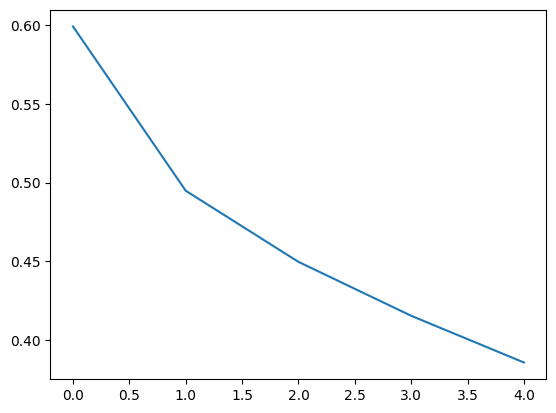

In [12]:
class CustomCallback(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        model_name = f"/kaggle/working/{Config.lora_name}_{Config.lora_rank}_last.lora.h5"
        gemma.backbone.save_lora_weights(model_name)

        # Evaluate
        text_gen("a grass (Eleusine indica) used for sacrificial litter (barhis), fuel, and making baskets and other products")
        text_gen(
          "a species of grass (Panicum dactylon)"
        )
        text_gen(
          "handle of a plough or a beaker"
        )
        text_gen("a stalk of reed grass, often denotes fragility")

history = gemma.fit(train, epochs=Config.train_epoch, batch_size=1, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()